In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cpi

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer,
    mean_squared_log_error,
)
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_33512\989408937.py:5: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  import cpi


In [2]:
data = pd.read_csv("train.csv")
data = data[data["runtime"] >= 10]
data = data[data["budget"] != 0]
data = data[data["revenue"] >= 1000]

In [3]:
# Compute 'col_size' where from 'col' column, which contains a str presentation of a list of dictionaries
for col in [
    # "genres",
    # "production_companies",
    # "production_countries",
    # "spoken_languages",
    # "Keywords",
    "cast",
    "crew",
]:
    data[col] = data[col].fillna("[]")
    data[f"{col}_size"] = data[col].apply(lambda x: len(eval(str("list(" + x + ")"))))

In [4]:
# Extract temporal features from release_date
data["release_date"] = pd.to_datetime(data["release_date"])
# Convert years beyond 2023 to 100 years ago
data["release_date"] = data["release_date"].apply(
    lambda x: x if x.year < 2023 else x.replace(year=x.year - 100)
)
data["week_number"] = data["release_date"].dt.isocalendar().week
# Adjust week number for the movies released in the last week of the year
data["week_number"] = data["week_number"].apply(lambda x: 1 if x == 53 else x)
# Adjust budget for inflation with CPI
data["budget_adj"] = data.apply(
    lambda x: cpi.inflate(x["budget"], x["release_date"].year), axis=1
)
# Adjust revenue for inflation with CPI
data["revenue"] = data.apply(
    lambda x: cpi.inflate(x["revenue"], x["release_date"].year), axis=1
)

C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_33512\2971209175.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["release_date"] = pd.to_datetime(data["release_date"])


In [5]:
def target_encoding(data, col):
    data[col] = data[col].fillna("[]")
    data = data[(data[col] != "[]") & (data[col] != "")]
    data[col] = data[col].apply(lambda x: eval(str("list(" + x + ")")))
    data[col] = data[col].apply(lambda x: [i["id"] for i in x])
    flattened = [item for sublist in data[col] for item in sublist]
    target_df = pd.DataFrame(
        {"col": flattened, "revenue": data["revenue"].repeat(data[col].apply(len))}
    )
    target_means = target_df.groupby("col")["revenue"].mean()
    data[f"encoded_{col}"] = data[col].apply(lambda x: [target_means[g] for g in x])
    data[f"encoded_{col}"] = data[f"encoded_{col}"].apply(lambda x: np.mean(x))

    # Also saves this encoding to a csv file
    target_means.to_csv(f"encoded_{col}.csv")

    return data


data = target_encoding(data, "genres")
data = target_encoding(data, "production_companies")
data = target_encoding(data, "crew")
data = target_encoding(data, "cast")

C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_33512\2354914387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x: eval(str("list(" + x + ")")))
C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_33512\2354914387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x: [i["id"] for i in x])
C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_33512\2354914387.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [6]:
data.drop(
    [
        "id",
        "budget",
        "belongs_to_collection",
        "genres",
        "homepage",
        "imdb_id",
        "original_language",
        "original_title",
        "overview",
        "poster_path",
        "production_companies",
        "production_countries",
        "release_date",
        "spoken_languages",
        "status",
        "tagline",
        "title",
        "Keywords",
        "cast",
        "crew",
    ],
    axis=1,
    inplace=True,
)
data.dropna(inplace=True)

In [7]:
data

,popularity,runtime,revenue,cast_size,crew_size,week_number,budget_adj,encoded_genres,encoded_production_companies,encoded_crew,encoded_cast
0,6.575393,93.0,1.520542e+07,24,72,8,4.938971e+06,1.037271e+08,2.003292e+08,4.383439e+07,6.776418e+07
1,8.248895,113.0,1.474111e+08,20,9,32,3.873147e+07,1.305905e+08,4.605199e+08,1.544209e+08,2.255189e+08
2,64.299990,105.0,1.618444e+07,51,64,41,1.236208e+07,8.549816e+07,7.418025e+07,5.462063e+07,5.099292e+07
6,7.286477,92.0,1.089150e+08,14,77,35,7.647979e+07,1.061932e+08,1.120948e+08,1.239189e+08,1.151602e+08
10,14.774066,119.0,6.029781e+08,37,31,47,4.114657e+07,8.549816e+07,1.979174e+08,4.175519e+08,4.709227e+08
...,...,...,...,...,...,...,...,...,...,...,...
2993,14.092373,128.0,3.399341e+08,23,68,25,5.422406e+05,9.461262e+07,3.646709e+08,3.293069e+08,2.412568e+08
2994,7.438381,106.0,3.069450e+07,7,17,38,5.214808e+07,8.549816e+07,2.340090e+08,1.121024e+08,6.897357e+07
2995,9.853270,102.0,3.153026e+06,15,17,16,9.676177e+07,1.028248e+08,1.585880e+08,7.013163e+07,9.746552e+07
2996,3.727996,102.0,2.268683e+05,11,15,13,6.658188e+07,8.943088e+07,1.538453e+07,2.460663e+05,1.208341e+06


In [8]:
data.describe()

,popularity,runtime,revenue,cast_size,crew_size,week_number,budget_adj,encoded_genres,encoded_production_companies,encoded_crew,encoded_cast
count,2139.000000,2139.000000,2.139000e+03,2139.000000,2139.000000,2139.000000,2.139000e+03,2.139000e+03,2.139000e+03,2.139000e+03,2.139000e+03
mean,8.795600,108.665732,1.214571e+08,21.532024,26.142122,27.747078,7.760950e+07,1.240751e+08,1.310316e+08,1.372324e+08,1.372876e+08
std,11.517473,20.205747,2.213378e+08,16.632755,28.941886,14.817319,2.270694e+08,4.271810e+07,1.349128e+08,1.622888e+08,1.576011e+08
min,0.000308,40.000000,1.845449e+03,1.000000,1.000000,1.000000,1.333656e+02,5.698500e+06,1.845449e+03,2.386107e+03,9.326488e+03
25%,4.785379,95.000000,6.900624e+06,12.000000,9.000000,15.000000,1.006802e+07,9.612783e+07,2.768909e+07,3.410837e+07,5.251619e+07
50%,7.668829,105.000000,3.981369e+07,17.000000,16.000000,29.000000,2.880463e+07,1.037271e+08,1.069808e+08,9.692592e+07,9.958432e+07
75%,11.050331,119.000000,1.319506e+08,25.000000,31.000000,40.000000,7.398979e+07,1.480633e+08,1.851453e+08,1.773694e+08,1.639527e+08
max,287.253654,248.000000,2.560209e+09,156.000000,194.000000,52.000000,6.316295e+09,2.851657e+08,1.011896e+09,1.719467e+09,1.932341e+09


In [9]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop("revenue", axis=1)
y_train = train["revenue"]
X_test = test.drop("revenue", axis=1)
y_test = test["revenue"]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1711, 10) (1711,)
(428, 10) (428,)


In [10]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [11]:
# Grid search for best RandomForestRegressor with custom RMSEL scorer
param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [5, 10, 15, 20, 25, 30],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9],
}
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    cv=5,
    scoring=rmsle_scorer,
    verbose=10,
)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [12]:
model = make_pipeline(
    StandardScaler(),
    # RandomForestRegressor(
    #     max_depth=30, min_samples_leaf=8, min_samples_split=7, n_estimators=20
    # ),
    RandomForestRegressor(),
)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [13]:
print(
    "Train R2:",
    cross_val_score(model, X_train, y_train, cv=5, scoring=rmsle_scorer).mean(),
)
print(
    "Test R2:",
    cross_val_score(model, X_test, y_test, cv=5, scoring=rmsle_scorer).mean(),
)

Train R2: -1.1615447964763588
Test R2: -1.4107928888435792


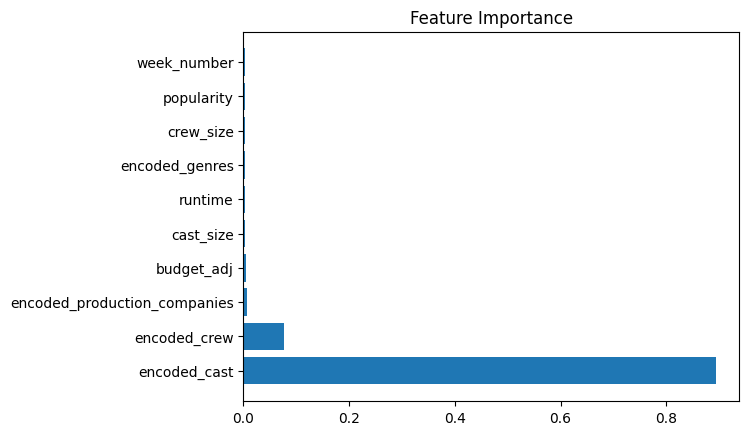

In [14]:
# Get feature importances
importances = model.named_steps["randomforestregressor"].feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
# Horizontal Bar Plot
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), names)
plt.show()